In [1]:
import openmc
import openmc.mgxs as mgxs
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
sp_flat = openmc.StatePoint('./flux_study_flat/statepoint.80.h5')
sp_minimized = openmc.StatePoint('./flux_study/statepoint.80.h5')

In [3]:
def get_ppf_fuel(sp, pf_z):
    mesh_tally = sp.get_tally(name='fqr')
    fqro = mesh_tally.get_slice(scores=['fission-q-recoverable'])
    nu_fission = mesh_tally.get_slice(scores=['nu-fission'])
    fission = mesh_tally.get_slice(scores=['fission'])
    fqro_list = fqro.mean
    fqro_list.shape = (5,10)
    fqro_array = np.array(fqro_list)
    pf = [pf_z] * 5
    pf_array = np.array(pf_z)
    ppf = np.max((fqro_array/ pf_array))/ np.mean(fqro_array/ pf_array)
    return ppf

In [4]:
get_ppf_fuel(sp_flat, [0.0979]*10)
# vs 1.046

1.0894715844427068

In [5]:
def flux_total(sp):
    tally_flux_all = sp.get_tally(name='flux_all')
    flux_all = tally_flux_all.get_slice(scores=['flux'])
    nu_fission_all = tally_flux_all.get_slice(scores=['nu-fission'])
    fission_all = tally_flux_all.get_slice(scores=['fission'])
    nu = sum(nu_fission_all.mean) / sum(fission_all.mean)
    Q = 200 * 1.6022e-13
    V = 27.1 * 3.25 * 1 / (100 * 20)
    k = sp.k_combined.n
    P = 1456
    N = P * nu / (Q * k)
    flux_all_vals = flux_all.mean * 1 / V * N
    flux_all_vals.shape = (20, 100)
    return flux_all_vals

In [6]:
27.1/100, 3.25/20

(0.271, 0.1625)

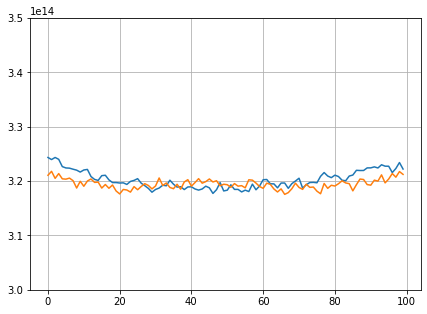

In [7]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(flux_total(sp_flat)[10])
ax.plot(flux_total(sp_minimized)[10])
ax.set_ylim(3.0e14, 3.5e14)
ax.grid()

In [8]:
def get_values(sp_file):
    tally_flux = sp_file.get_tally(name='flux')
    flux = tally_flux.get_slice(scores=['flux'])
    nu_fission = tally_flux.get_slice(scores=['nu-fission'])
    fission = tally_flux.get_slice(scores=['fission'])
    flux_conv_dict = {}
    eg_names = ['eg4', 'eg3', 'eg2', 'eg1']
    egs = [(1e-6, 1.8554), (1.8554, 2.9023e1), (2.9023e1, 9.1188e3), (9.1188e3, 2.0e7)]
    flux_eg, nu, nu_fiss_eg, fiss_eg = {}, {}, {}, {}
    for x in range(4):
        print(x)
        flux_eg[x] = flux.get_slice(
            filters=[
                openmc.EnergyFilter], filter_bins=[
                (egs[x],)])
        nu_fiss_eg[x] = nu_fission.get_slice(
            filters=[
                openmc.EnergyFilter], filter_bins=[
                (egs[x],)])
        fiss_eg[x] = fission.get_slice(
            filters=[
                openmc.EnergyFilter], filter_bins=[
                (egs[x],)])
        nu[x] = sum(nu_fiss_eg[x].mean) / sum(fiss_eg[x].mean)
    return flux_eg, nu, nu_fiss_eg, fiss_eg

In [9]:
def get_flux_dict_plank(k, P, z_thickness, nu, flux_eg):
    Q = 200 * 1.6022e-13
    V = 27.1 * 3.25 * z_thickness / (100 * 20)
    flux_conv_dict = {}
    eg_names = ['eg4', 'eg3', 'eg2', 'eg1']
    for x in range(4):
        N = P * nu[x] / (Q * k)
        flux_conv_dict[eg_names[x]] = flux_eg[x].mean * 1 / V * N
        flux_conv_dict[eg_names[x]].shape = (20, 100)
        flux_conv_dict[eg_names[x]][np.isnan(flux_conv_dict[eg_names[x]])] = 0
    return flux_conv_dict

In [10]:
flux_eg_flat, nu_flat, nu_fiss_flat, fiss_eg_flat = get_values(sp_flat)

0
1
2
3


In [11]:
flux_eg_minimized, nu_minimized, nu_fiss_minimized, fiss_eg_minimized = get_values(sp_minimized)

0
1
2
3


In [12]:
def get_fiss_dict(fiss_eg):
    eg_names = ['eg4', 'eg3', 'eg2', 'eg1']
    fiss_dict = {}
    for x in range(4):
        fiss_dict[eg_names[x]] = fiss_eg[x].mean
        fiss_dict[eg_names[x]].shape = (20, 100)
    return fiss_dict

In [13]:
fiss_dict_flat = get_fiss_dict(fiss_eg_flat)
fiss_dict_minimized = get_fiss_dict(fiss_eg_minimized)
nu_fiss_dict_flat = get_fiss_dict(nu_fiss_flat)
nu_fiss_dict_minimized = get_fiss_dict(nu_fiss_minimized)

0.004744158764632544 0.004749419656768825
minimized/flat 0.9988923084257709


Text(0.5, 1.0, 'Fission Group 1')

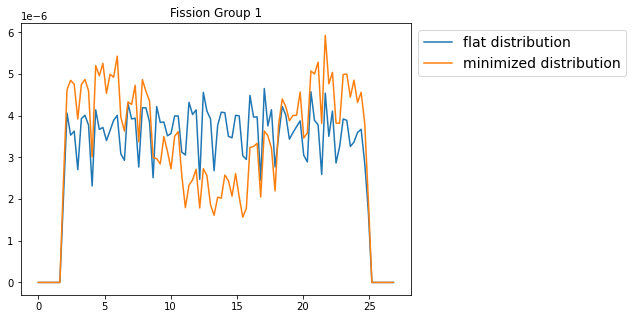

In [14]:
fig, ax = plt.subplots(figsize=(7,5))
x = np.arange(0, 27.1, 27.1/100)
ax.plot(x, fiss_dict_flat['eg1'][10], label="flat distribution")
ax.plot(x, fiss_dict_minimized['eg1'][10], label="minimized distribution")
print(sum(sum(fiss_dict_minimized['eg1'])), sum(sum(fiss_dict_flat['eg1'])))
print("minimized/flat", sum(sum(fiss_dict_minimized['eg1']))/sum(sum(fiss_dict_flat['eg1'])))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14, bbox_to_anchor = [1.0, 1.0])
ax.set_title("Fission Group 1")

0.500073688086208 0.50094523962408
minimized/flat 0.9982601860065063


Text(0.5, 1.0, 'Fission Group 4')

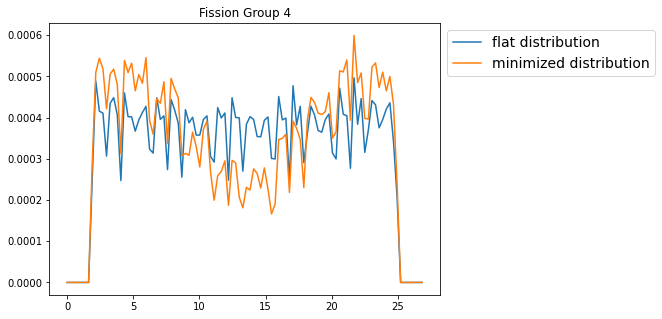

In [15]:
fig, ax = plt.subplots(figsize=(7,5))
x = np.arange(0, 27.1, 27.1/100)
ax.plot(x, fiss_dict_flat['eg4'][10], label="flat distribution")
ax.plot(x, fiss_dict_minimized['eg4'][10], label="minimized distribution")
print(sum(sum(fiss_dict_minimized['eg4'])), sum(sum(fiss_dict_flat['eg4'])))
print("minimized/flat", sum(sum(fiss_dict_minimized['eg4']))/sum(sum(fiss_dict_flat['eg4'])))
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14, bbox_to_anchor = [1.0, 1.0])
ax.set_title("Fission Group 4")
# Higher fission reaction rate 

In [17]:
power_moltres = 1456 # 1cm thick
flux_vals_flat = get_flux_dict_plank(sp_flat.k_combined.n, power_moltres, z_thickness=1, nu=nu_flat, flux_eg=flux_eg_flat)
flux_vals_minimized = get_flux_dict_plank(sp_minimized.k_combined.n, power_moltres, z_thickness=1, nu=nu_minimized, flux_eg=flux_eg_minimized)



In [18]:
def plot_flux(group, bot, top):
    x = np.arange(0, 27.1, 27.1/100)
    flux_flat = np.array(flux_vals_flat['eg'+str(group)][10])
    import scipy
    print('kuro flat',scipy.stats.kurtosis(flux_flat))
    flux_minimized = np.array(flux_vals_minimized['eg'+str(group)][10])
    print('kuro minimized',scipy.stats.kurtosis(flux_minimized))
    flat_max_min = max(flux_vals_flat['eg'+str(group)][10]) / min(flux_vals_flat['eg'+str(group)][10])
    minimized_max_min = max((flux_vals_minimized['eg'+str(group)][10]))/ min((flux_vals_minimized['eg'+str(group)][10]))
    print("flat", flat_max_min)
    print("min", minimized_max_min)
    print("min/flat", minimized_max_min/flat_max_min)
    print("%", (minimized_max_min-flat_max_min)/flat_max_min*100)
    fig, ax = plt.subplots(figsize=(11,7))
    ax.plot(x, flux_flat, label="constant distribution")
    ax.plot(x, flux_minimized, label=r'simulation p-1c: most-minimized $PPF_{fuel}$ distribution')
    ax.set_ylim(bot, top)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel('x [cm]', fontsize=20)
    ax.set_ylabel(r'Flux [$n \cdot cm{-^2}s^{-1}$]', fontsize=20)
    ax.set_title("Group "+str(group), fontsize=24)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, fontsize=18, bbox_to_anchor = [1.0, 1.0])
    ax.grid()
    ax.set_xlim(0, 27.1)
    plt.savefig("flux-comparison-0.0979-plank_grp"+str(group)+".png",bbox_inches='tight')

kuro flat -0.3720822816507967
kuro minimized 0.14924763778951666
flat 1.146790140821237
min 1.093093694851317
min/flat 0.953176746068407
% -4.682325393159299


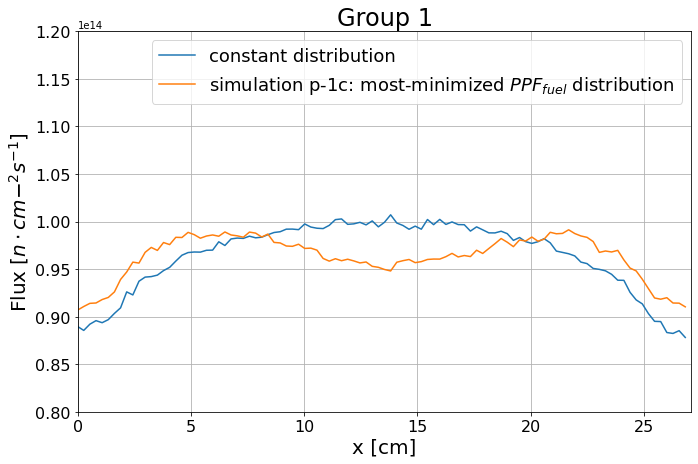

In [19]:
plot_flux(1, 0.8e14, 1.2e14)

kuro flat 0.017947748481421222
kuro minimized -0.40285118183333646
flat 1.0266446673423169
min 1.0243581803556894
min/flat 0.9977728545626731
% -0.2227145437326943


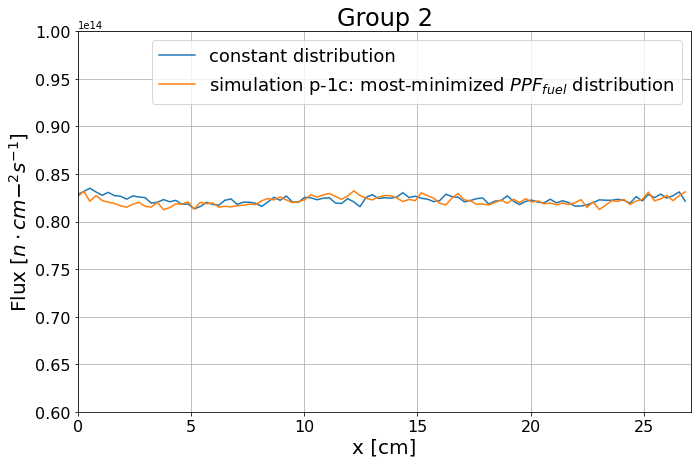

In [20]:
plot_flux(2, 0.6e14, 1e14)

kuro flat -0.3274126075205954
kuro minimized 0.6950865030079125
flat 1.1137350550992584
min 1.0766597830698004
min/flat 0.9667108691068776
% -3.3289130893122345


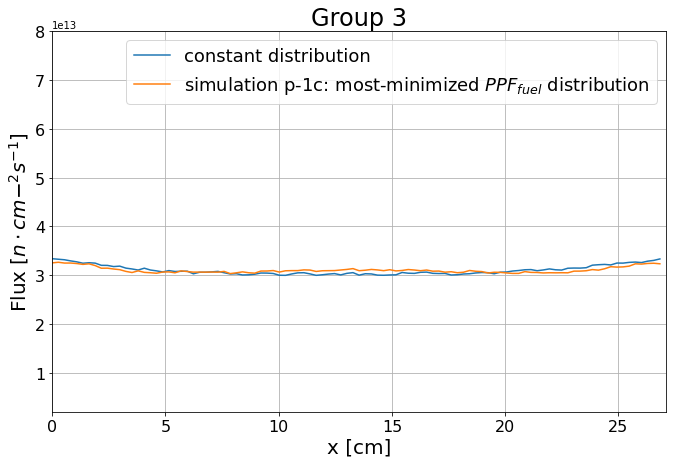

In [21]:
plot_flux(3, 0.2e13, 0.8e14)

kuro flat -0.78189765927443
kuro minimized 0.23040646852978064
flat 1.1152069581834005
min 1.071009269439902
min/flat 0.9603681734415523
% -3.9631826558447636


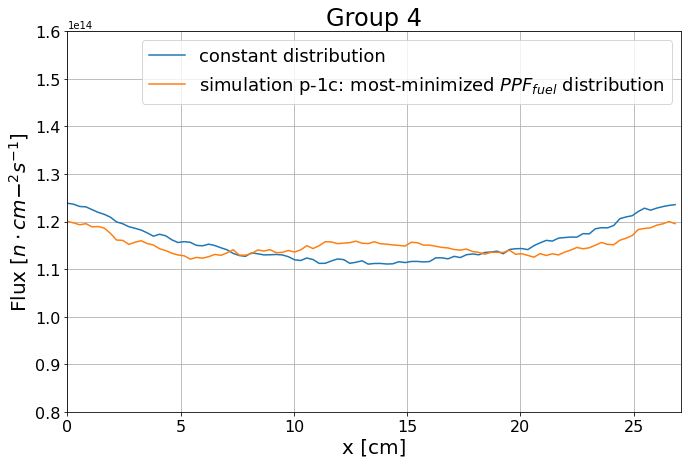

In [22]:
plot_flux(4, 0.8e14, 1.6e14) 
# more self shielding in a flat distribution 

In [23]:
# The dip in the constant $PF_{total}$ = 0.0979 thermal flux distribution is due to 
# self-shielding effects. 
# The lower the total PF, the less self-shielding that occurs.
# Thus, for a higher PF = 0.0979, a more drastic variation in TRISO distribution occurs to help flatten the 
# thermal (Group 4) flux. 


In [24]:
# self shielging explanation
# Higher PF means that there is more fuel, more self-shielding effects. 
# Varying the distribution is gonna 
# have a stronger effect in neutralizing self-shielding than in a lower PF case. 
# suggests 